In [11]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
torch.__version__
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_transform = transforms.Compose([
   
transforms.Resize(size=(256, 256)),
    
    
    
    transforms.Grayscale(num_output_channels=3),
    
    transforms.ToTensor() 
])

In [4]:
train_dir = r'C:\Users\pirat\Desktop\CSE499\unsupervised\train'
test_dir = r'C:\Users\pirat\Desktop\CSE499\unsupervised\test'

In [5]:
# Use ImageFolder to create datasets

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 318
    Root location: C:\Users\pirat\Desktop\CSE499\unsupervised\train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 183
    Root location: C:\Users\pirat\Desktop\CSE499\unsupervised\test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               ToTensor()
           )


In [6]:
# Get class names as a list
class_names = train_data.classes


# Can also get class names as a dict
class_dict = train_data.class_to_idx


# Check the lengths

len(train_data), len(test_data), class_names, class_dict

(318, 183, ['farcture', 'non-fracture'], {'farcture': 0, 'non-fracture': 1})

In [7]:
# Create dataloaders

from torch.utils.data import DataLoader

BATCH = 32
WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH,
                              num_workers=WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH,
                             num_workers=WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1be486b7410>,
 <torch.utils.data.dataloader.DataLoader at 0x1be486b72d0>)

In [8]:
import torchvision.models as models

class VGG16Binary(nn.Module):
    def __init__(self):
        super(VGG16Binary, self).__init__()
        self.vgg16 = models.vgg16(weights=True)
        # Freeze all the layers in the VGG16 model
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer with a custom binary classifier
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2),  # Binary classification - 2 output classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.vgg16(x)
model = VGG16Binary().to(device)

C:\Users\pirat\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
VGG16Binary                              [1, 2]                    --
├─VGG: 1-1                               [1, 2]                    --
│    └─Sequential: 2-1                   [1, 512, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]    

Epoch 1/5, Train Loss: 0.4721, Train Accuracy: 77.04%, Test Loss: 0.7523, Test Accuracy: 55.19%
Epoch 2/5, Train Loss: 0.3315, Train Accuracy: 84.59%, Test Loss: 0.5352, Test Accuracy: 74.86%
Epoch 3/5, Train Loss: 0.2439, Train Accuracy: 90.57%, Test Loss: 0.4859, Test Accuracy: 77.05%
Epoch 4/5, Train Loss: 0.2114, Train Accuracy: 90.88%, Test Loss: 0.5736, Test Accuracy: 74.86%
Epoch 5/5, Train Loss: 0.2060, Train Accuracy: 90.88%, Test Loss: 0.6408, Test Accuracy: 73.77%


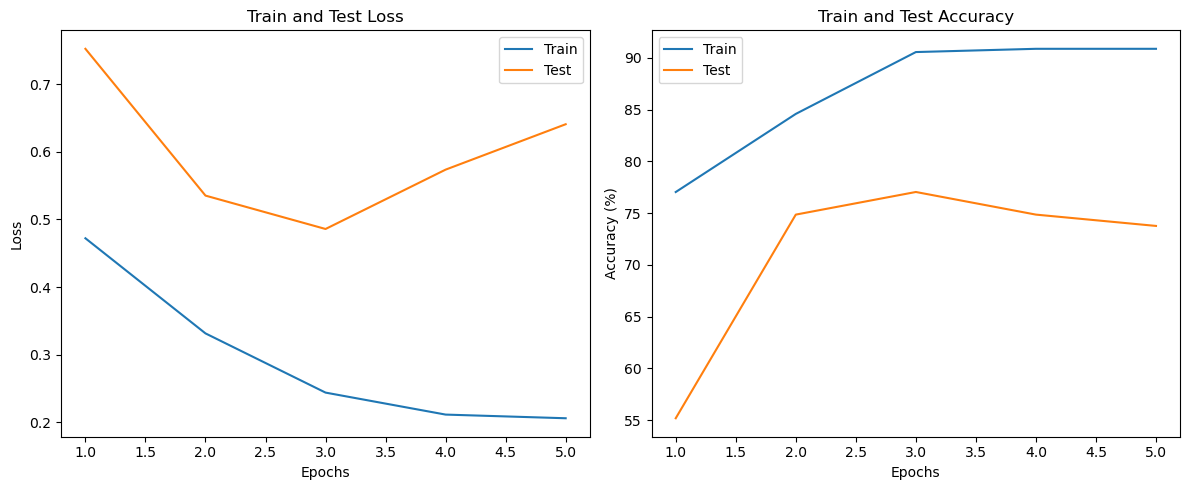

In [10]:
model = VGG16Binary().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

# Lists to store loss and accuracy values for train and test data
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * total_train_correct / total_train_samples
    train_loss /= len(train_dataloader.dataset)

    # Validation (Test data)
    model.eval()
    test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * total_test_correct / total_test_samples
    test_loss /= len(test_dataloader.dataset)

    # Append loss and accuracy values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot the loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train and Test Accuracy')

plt.tight_layout()
plt.show()